colab link:

https://colab.research.google.com/drive/1fIhXpxsLhBl8Xr6kTOifkkqSdIF0i6fk?usp=sharing

video link:

https://drive.google.com/file/d/1P21ILj0EjD02jZy1QtE8LnHgX_xlcclf/view?usp=sharing

Deep Learning RNN-HO


# RECURRENT NEURAL NETWORK (RNN)



*   RNNs are a class of neural networks that allow previous outputs
to be used as inputs while having hidden states

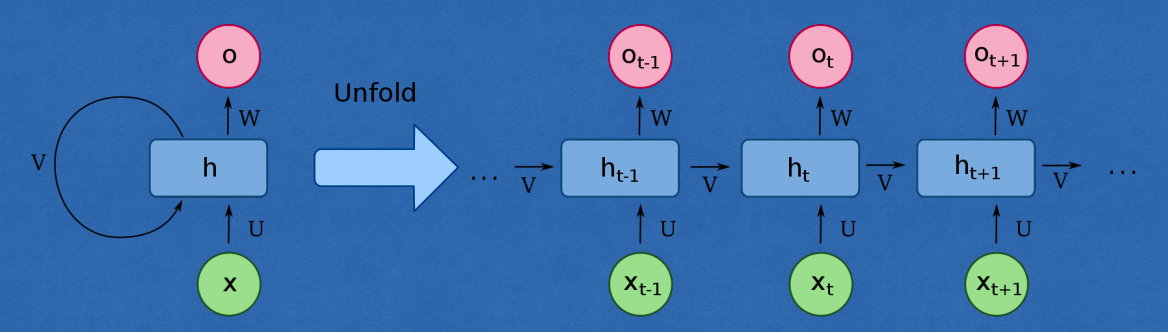



# RNN Aplications


*   The core reason that RNNs are so exciting is that they allow us to operate
over sequences of vectors.

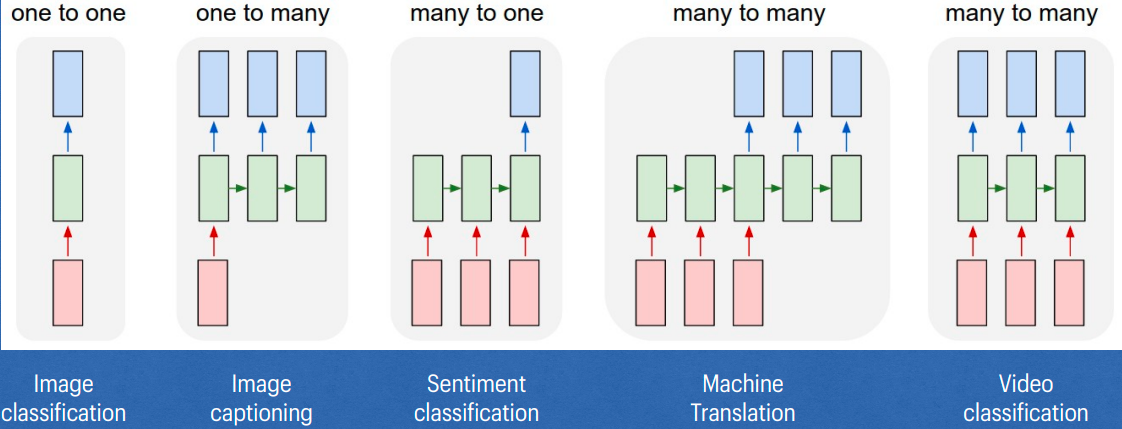



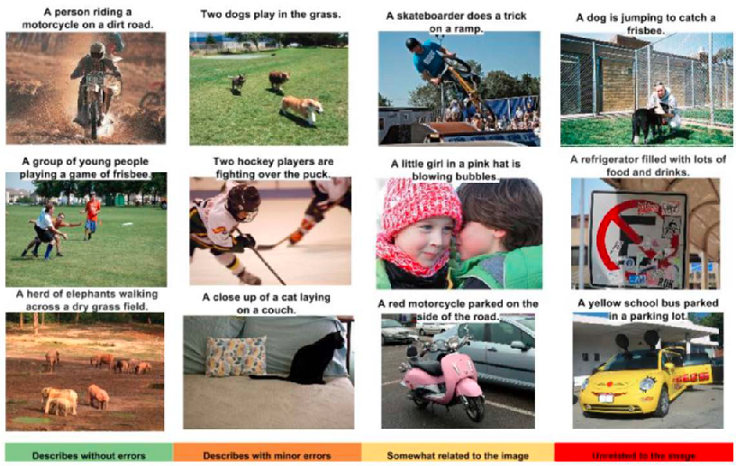

# RNN example - from scratch

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

--2021-12-03 10:46:57--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.62.61, 13.226.62.19, 13.226.62.81, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.62.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  13.6MB/s    in 0.2s    

2021-12-03 10:46:58 (13.6 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [ ]:
!unzip data.zip

In [ ]:

import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories


# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**One hot encoding**


*   A one-hot vector is filled with 0s except for a 1 at index of the current letter.

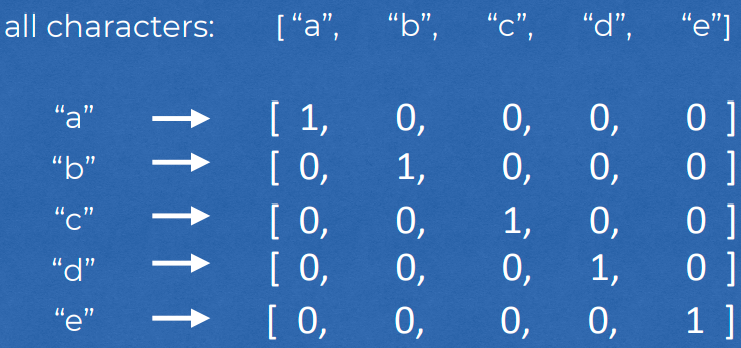



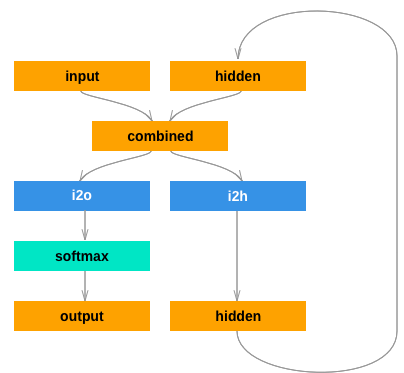

In [ ]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self): # zero initial 
        return torch.zeros(1, self.hidden_size)
    
category_lines, all_categories = load_data()  # dictionary of the countries and names , a list of different contries 
n_categories = len(all_categories)
print(n_categories)
print(N_LETTERS) # comes from len ALL_LETTERS

18
57


**What is the advantage of using log softmax instead of softmax?**

refer to this [link](https://datascience.stackexchange.com/questions/40714/what-is-the-advantage-of-using-log-softmax-instead-of-softmax)

In [ ]:
n_hidden = 128               #hyperparameter
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())


torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Spanish


5000 5.0 3.0434 Arai / Vietnamese WRONG (Japanese)
10000 10.0 1.3853 Shin / Chinese WRONG (Korean)
15000 15.0 0.2220 Nakahara / Japanese CORRECT
20000 20.0 2.8238 Habich / Arabic WRONG (German)
25000 25.0 0.6646 Chin / Korean CORRECT
30000 30.0 2.7403 Grinham / Irish WRONG (English)
35000 35.0 0.8203 Ceallach / Irish CORRECT
40000 40.0 0.0517 Tochikura / Japanese CORRECT
45000 45.0 2.8461 Adlersflugel / Portuguese WRONG (German)
50000 50.0 2.7102 Asom / Arabic WRONG (English)
55000 55.00000000000001 2.6715 Dennis / Greek WRONG (English)
60000 60.0 0.3720 Mcgregor / Scottish CORRECT
65000 65.0 3.6717 Wakeham / Arabic WRONG (English)
70000 70.0 3.3934 Bonnay / Arabic WRONG (French)
75000 75.0 1.5863 Chaim / Korean WRONG (Chinese)
80000 80.0 2.1952 Naizer / Arabic WRONG (Czech)
85000 85.0 0.3175 Zeng / Chinese CORRECT
90000 90.0 0.0015 Haritopoulos / Greek CORRECT
95000 95.0 0.0580 Abbadelli / Italian CORRECT
100000 100.0 0.5796 Hernandez / Spanish CORRECT


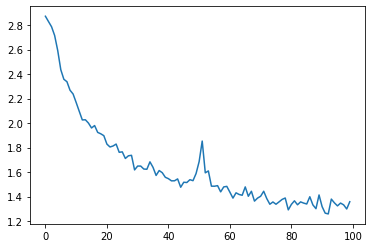

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    # append mean loss every 1000 step 
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")
           
plt.figure()
plt.plot(all_losses)
plt.show()

In [ ]:
# you can try names
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)

Input:Ahmad

> Ahmad
Arabic
Input:Stive

> Stive
French
Input:Xio

> Xio
Chinese
Input:quit


Email: arash.lagzian94@gmail.com